# LOw Code

Algorithme (1  seule itération)

In [ ]:
import re
import tensorflow as tf


french="Les sciences exactes, telles que les mathématiques et la physique, étudient des phénomènes mesurables et prédictibles. Elles reposent sur des démonstrations rigoureuses et des observations empiriques, menant à une compréhension approfondie du monde."
english="Exact sciences, such as mathematics and physics, study measurable and predictable phenomena. They rely on rigorous demonstrations and empirical observations, leading to a profound understanding of the world."

fr_to_id={
  "Les": 1,
  "sciences": 2,
  "exactes": 3,
  "telles": 4,
  "que": 5,
  "les": 6,
  "mathématiques": 7,
  "et": 8,
  "la": 9,
  "physique": 10,
  "étudient": 11,
  "des": 12,
  "phénomènes": 13,
  "mesurables": 14,
  "prédictibles": 15,
  "Elles": 16,
  "reposent": 17,
  "sur": 18,
  "démonstrations": 19,
  "rigoureuses": 20,
  "observations": 21,
  "empiriques": 22,
  "menant": 23,
  "à": 24,
  "une": 25,
  "compréhension": 26,
  "approfondie": 27,
  "du": 28,
  "monde": 29
}


en_to_id={
  "Exact": 1,
  "sciences": 2,
  "such": 3,
  "as": 4,
  "mathematics": 5,
  "and": 6,
  "physics": 7,
  "study": 8,
  "measurable": 9,
  "predictable": 10,
  "phenomena": 11,
  "They": 12,
  "rely": 13,
  "on": 14,
  "rigorous": 15,
  "demonstrations": 16,
  "empirical": 17,
  "observations": 18,
  "leading": 19,
  "to": 20,
  "a": 21,
  "profound": 22,
  "understanding": 23,
  "of": 24,
  "the": 25,
  "world": 26
}

french_cleaned=re.split(r'[ ,.]+',french)
#french_cleaned=french_cleaned.remove('')
english_cleaned=re.split(r'[ ,.]+',english)
src=[]
tgt=[]
for fr_word,en_word in zip(french_cleaned,english_cleaned):
    if fr_word in fr_to_id:
        src.append(fr_to_id[fr_word])
    if en_word in en_to_id:
        tgt.append(en_to_id[en_word])

tf_src=tf.constant([src])
tf_tgt=tf.constant([tgt])

#print("French Tensor",tf_src)
#print("English Tensor",tf_tgt)
vocab_size=len(src)
embed_dim=100
units=16
encoder_input=tf_src

In [ ]:
def encoder(encoder_input):
    #encoder_input=tf.expand_dims(tf_src,axis=1)
    embedding=tf.keras.layers.Embedding(vocab_size,embed_dim)
    encoder_input=embedding(encoder_input)
    lstm=tf.keras.layers.LSTM(units,return_sequences=True,return_state=True)
    encoder_output,h_state,c_state=lstm(encoder_input)
    #print(french_cleaned)

    #english_cleaned=re.split(r'[ ,.]+',english)*
    return encoder_output,h_state,c_state

def decoder(decoder_input,vocab_size,embed_dim,enc_h_state,enc_c_state):
    dec_embedding=tf.keras.layers.Embedding(vocab_size,embed_dim)
    decoder_input=dec_embedding(decoder_input)
    decoder_lstm=tf.keras.layers.LSTM(units,return_sequences=True,return_state=True)
    decoder_output,h_state , c_state=decoder_lstm(decoder_input,initial_state=[enc_h_state,enc_c_state])
    return decoder_output,h_state , c_state

out,h,c=encoder(encoder_input)
#part_tgt=tf.expand_dims(tf_tgt[:-6],axis=1)
dec_out,dec_h,dec_c=decoder(tf_tgt,vocab_size,embed_dim,h,c)

inf_dense=tf.keras.layers.Dense(vocab_size)
logits=inf_dense(dec_out)

pred_id=tf.argmax(logits,axis=1)
print("Indice prédit",pred_id.numpy())
target_id=list(pred_id.numpy()[0])
reverse_english={id:word for word,id in en_to_id.items()}
response=[reverse_english[i] for i in target_id if i in en_to_id.values() ]#elif i==max(en_to_id.values()+1)]
print(" ".join(response))

Indice prédit [[25  4  7 20  0  0 25  6 10  0 25  0  0  7 21 23  7  9 27  7 26 26 27 26
  15  6  7  9 16]]
the as physics to the and predictable the physics a understanding physics measurable physics world world world rigorous and physics measurable demonstrations


## low model

### nmt without attention

In [ ]:
from tensorflow.keras.models import Model

#Encoder
encoder_input=tf.keras.layers.Input(shape=(None,))
encoder_embedding=tf.keras.layers.Embedding(vocab_size,embed_dim)(encoder_input)

enc_output,enc_h,enc_c=tf.keras.layers.LSTM(units,return_sequences=True,return_state=True)(encoder_embedding) #Normalement ça devait être un bidirectional LSTM

decoder_input=tf.keras.layers.Input(shape=(None,))
decoder_lstm = tf.keras.layers.LSTM(units,return_sequences=True,return_state=True)
decoder_embedding=tf.keras.layers.Embedding(vocab_size,embed_dim)(decoder_input)
decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=[enc_h,enc_c])

logits = inf_dense(decoder_output) # Apply dense layer to LSTM output
simple_nmt=Model(inputs=[encoder_input,decoder_input],outputs=logits)

In [ ]:
simple_nmt.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, None, 100) │      2,900 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, None, 100) │      2,900 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, None,     │      7,488 │ embedding_8[0][0] │
│                     │ 16), (None, 16),  │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, None,     │      7,488 │ embedding_9[0][0… │
│                     │ 16), (None, 16),  │            │ lstm_9[0][1],     │
│                     │ (None, 16)]       │            │ lstm_9[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 29)  │        493 │ lstm_10[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,269 (83.08 KB)

 Trainable params: 21,269 (83.08 KB)

 Non-trainable params: 0 (0.00 B)

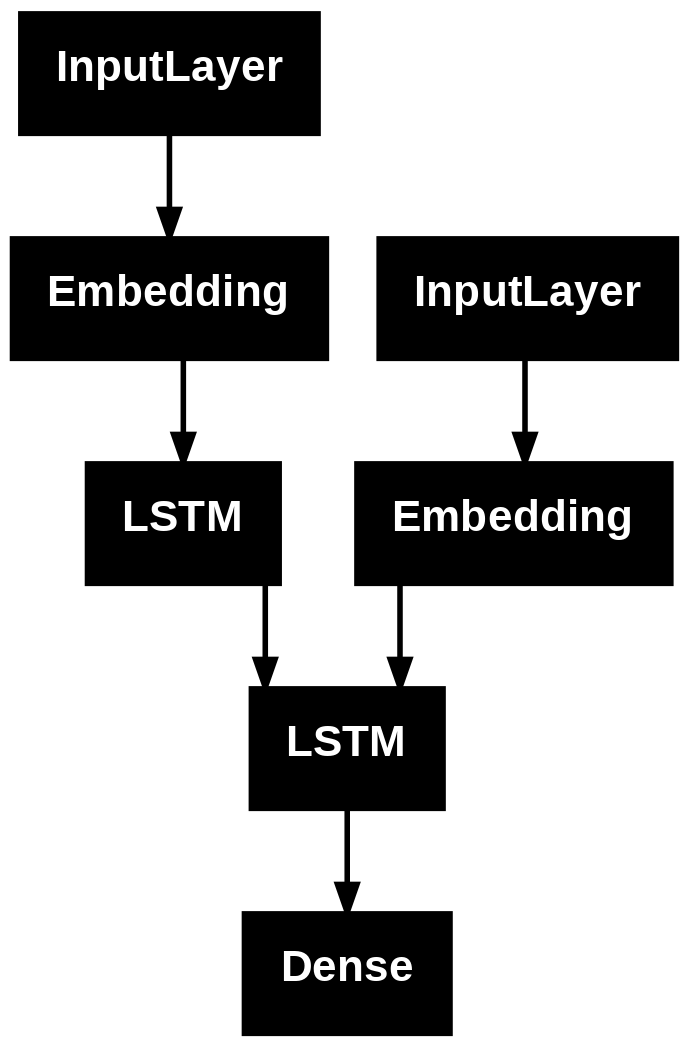

In [ ]:
tf.keras.utils.plot_model(simple_nmt)

In [ ]:
simple_nmt.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["sparse_categorical_accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)


In [ ]:
#Data
import numpy as np
input_data=np.array([src])
decoder_input_data=np.array([tgt[:-1]])
decoder_output_data=np.array([tgt[1:]])

In [ ]:

simple_nmt.fit([input_data,decoder_input_data],decoder_output_data,batch_size=1,epochs=30)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 3.3686 - sparse_categorical_accuracy: 0.0370
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.3641 - sparse_categorical_accuracy: 0.0370
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3596 - sparse_categorical_accuracy: 0.1481
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 3.3551 - sparse_categorical_accuracy: 0.2593
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.3506 - sparse_categorical_accuracy: 0.3333
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.3460 - sparse_categorical_accuracy: 0.3333
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.3414 - sparse_categorical_accuracy: 0.3333
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.3366 - sparse_categorical_accuracy: 0.3333
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3316 - sparse_categorical_accuracy: 0.3333
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 3.3265 - sparse_categorica

In [ ]:
for i in range(len(simple_nmt.layers)):
  print(f"N° {i} : {simple_nmt.layers[i]}")

N° 0 : <InputLayer name=input_layer_9, built=True>
N° 1 : <InputLayer name=input_layer_10, built=True>
N° 2 : <Embedding name=embedding_10, built=True>
N° 3 : <Embedding name=embedding_11, built=True>
N° 4 : <LSTM name=lstm_11, built=True>
N° 5 : <LSTM name=lstm_12, built=True>
N° 6 : <Dense name=dense, built=True>


In [ ]:
simple_nmt.layers[]

In [ ]:
inf_embedding=simple_nmt.layers[2](tf_src)
out,h,c=simple_nmt.layers[4](inf_embedding)
#part_tgt=tf.expand_dims(tf_tgt[:-6],axis=1)

#Dense
target_ids=np.array([[1]])
embed_target=simple_nmt.layers[3](target_ids)
dec_out,dec_h,dec_c=simple_nmt.layers[5](embed_target,initial_state=[h,c])

#inf_dense=tf.keras.layers.Dense(vocab_size)
inf_dense=simple_nmt.layers[6]
logits=inf_dense(dec_out)
logits=logits[:,-1,:]
pred_id=tf.argmax(logits,axis=1)
print(pred_id)
print("Indice prédit",pred_id.numpy())
target_id=list(pred_id.numpy())  #target_id=list(pred_id.numpy()[0])
reverse_english={id:word for word,id in en_to_id.items()}
response=[reverse_english[i] for i in target_id if i in en_to_id.values() ]#elif i==max(en_to_id.values()+1)]
print(" ".join(response))

tf.Tensor([2], shape=(1,), dtype=int64)
Indice prédit [2]
sciences


In [ ]:
start='<sos>'  end='eos'

In [ ]:
#Dense
j=0
inputs_j=[1]
reverse_english={id:word for word,id in en_to_id.items()}
results_id=[]
#while True:
for j in range(25):
  target_ids=np.array([inputs_j])
  embed_target=simple_nmt.layers[3](target_ids)
  dec_out,dec_h,dec_c=simple_nmt.layers[5](embed_target,initial_state=[h,c])

  #inf_dense=tf.keras.layers.Dense(vocab_size)
  inf_dense=simple_nmt.layers[6]
  logits=inf_dense(dec_out)
  logits=logits[:,-1,:]
  pred_id=tf.argmax(logits,axis=1)
  #print(pred_id)
  #print("Indice prédit",pred_id.numpy())
  token_id=pred_id.numpy()[0]
  results_id.append(token_id)  #target_id=list(pred_id.numpy()[0])

  inputs_j.append(j+1)
print("Result_ids",results_id)
response=[reverse_english[i] for i in results_id if i in en_to_id.values() ]#elif i==max(en_to_id.values()+1)]
print("Entrée :",french)
print(" ".join(response))


Result_ids [np.int64(2), np.int64(2), np.int64(4), np.int64(4), np.int64(4), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(20), np.int64(20), np.int64(20), np.int64(19), np.int64(21), np.int64(21), np.int64(15), np.int64(25)]
Entrée : Les sciences exactes, telles que les mathématiques et la physique, étudient des phénomènes mesurables et prédictibles. Elles reposent sur des démonstrations rigoureuses et des observations empiriques, menant à une compréhension approfondie du monde.
sciences sciences as as as and and and and and and and and and and and and to to to leading a a rigorous the


# NMT WITH ATTENTION

In [ ]:
#Encoder
encoder_input=tf.keras.layers.Input(shape=(None,))
encoder_embedding=tf.keras.layers.Embedding(vocab_size,embed_dim)(encoder_input)

enc_output,enc_h,enc_c=tf.keras.layers.LSTM(units,return_sequences=True,return_state=True)(encoder_embedding) #Normalement ça devait être un bidirectional LSTM

decoder_input=tf.keras.layers.Input(shape=(None,))
decoder_lstm = tf.keras.layers.LSTM(units,return_sequences=True,return_state=True)
decoder_embedding=tf.keras.layers.Embedding(vocab_size,embed_dim)(decoder_input)

add_attention=tf.keras.layers.AdditiveAttention()

decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=[enc_h,enc_c])

context_vector=add_attention([decoder_output,enc_output])
rich_vector=tf.keras.layers.concatenate([context_vector,decoder_output],axis=-1)
logits = tf.keras.layers.Dense(vocab_size)(rich_vector) # Apply dense layer to LSTM output
nmt_with_addAtt=Model(inputs=[encoder_input,decoder_input],outputs=logits)

In [ ]:
nmt_with_addAtt.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_26      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_26        │ (None, None, 100) │      2,900 │ input_layer_25[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_27        │ (None, None, 100) │      2,900 │ input_layer_26[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ [(None, None,     │      7,488 │ embedding_26[0][… │
│                     │ 16), (None, 16),  │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ [(None, None,     │      7,488 │ embedding_27[0][… │
│                     │ 16), (None, 16),  │            │ lstm_27[0][1],    │
│                     │ (None, 16)]       │            │ lstm_27[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention… │ (None, None, 16)  │         16 │ lstm_28[0][0],    │
│ (AdditiveAttention) │                   │            │ lstm_27[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, None, 32)  │          0 │ additive_attenti… │
│ (Concatenate)       │                   │            │ lstm_28[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, None, 29)  │        957 │ concatenate_4[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,749 (84.96 KB)

 Trainable params: 21,749 (84.96 KB)

 Non-trainable params: 0 (0.00 B)

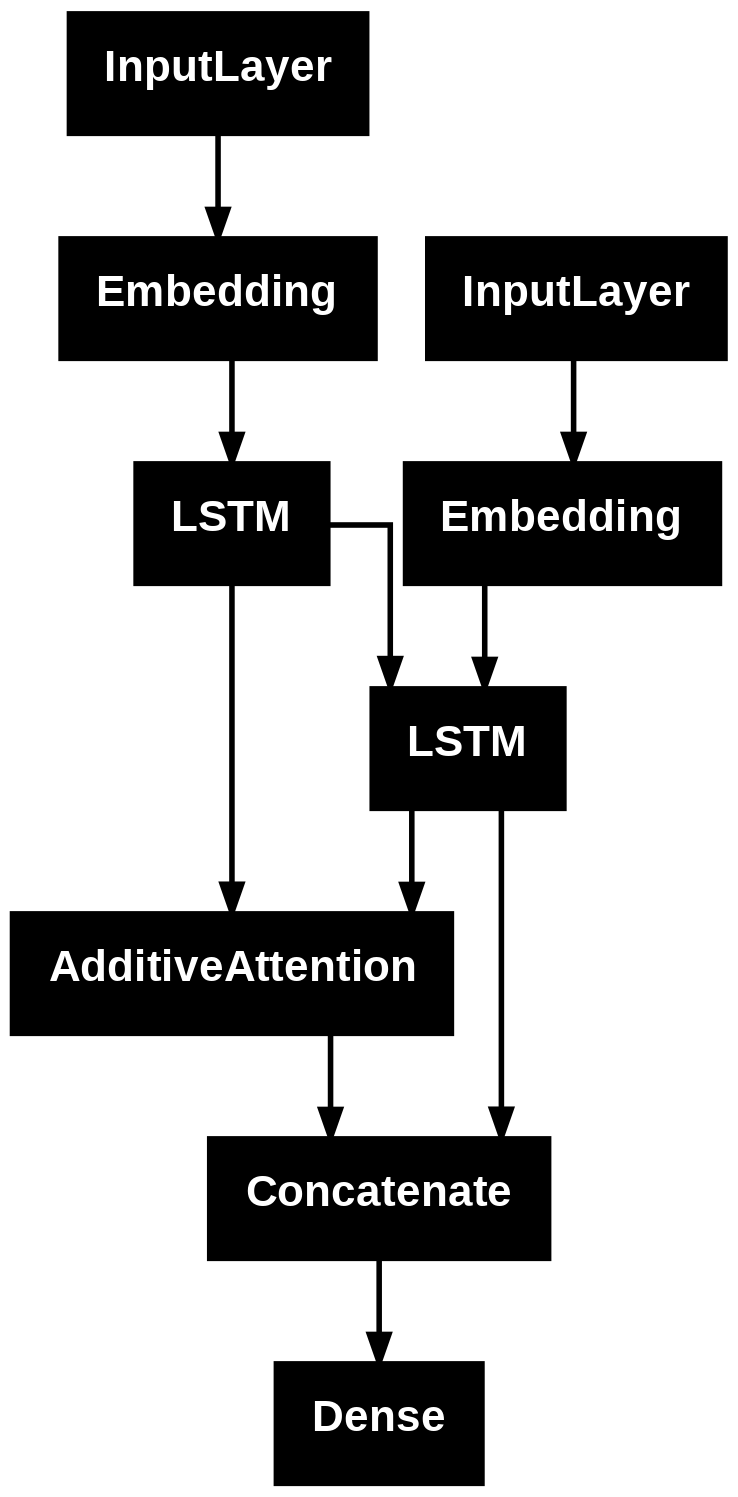

In [ ]:
tf.keras.utils.plot_model(nmt_with_addAtt)

In [ ]:
nmt_with_addAtt.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["sparse_categorical_accuracy"])

In [ ]:
nmt_with_addAtt.fit([input_data,decoder_input_data],decoder_output_data,epochs=30)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 6.7694 - sparse_categorical_accuracy: 0.0741
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 6.3196 - sparse_categorical_accuracy: 0.0370
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 6.1569 - sparse_categorical_accuracy: 0.2222
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 5.6602 - sparse_categorical_accuracy: 0.1481
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 5.8981 - sparse_categorical_accuracy: 0.1481
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 5.8279 - sparse_categorical_accuracy: 0.1481
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 5.7469 - sparse_categorical_accuracy: 0.1852
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.6431 - sparse_categorical_accuracy: 0.1852
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 5.5152 - sparse_categorical_accuracy: 0.2222
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 5.3803 - sparse_categor

In [ ]:
for i in range(len(nmt_with_addAtt.layers)):
  print(f"N° {i} : {nmt_with_addAtt.layers[i]}")

N° 0 : <InputLayer name=input_layer_25, built=True>
N° 1 : <InputLayer name=input_layer_26, built=True>
N° 2 : <Embedding name=embedding_26, built=True>
N° 3 : <Embedding name=embedding_27, built=True>
N° 4 : <LSTM name=lstm_27, built=True>
N° 5 : <LSTM name=lstm_28, built=True>
N° 6 : <AdditiveAttention name=additive_attention_7, built=True>
N° 7 : <Concatenate name=concatenate_4, built=True>
N° 8 : <Dense name=dense_7, built=True>


In [ ]:
inf_embedding=nmt_with_addAtt.layers[2](tf_src)
out,h,c=nmt_with_addAtt.layers[4](inf_embedding)

j=0
inputs_j=[1]
reverse_english={id:word for word,id in en_to_id.items()}
results_id=[]
#while True:
for j in range(25):
  target_ids=np.array([inputs_j])
  #DECODER EMBEDDING
  embed_target=nmt_with_addAtt.layers[3](target_ids)
  #LSTM
  dec_out,dec_h,dec_c=nmt_with_addAtt.layers[5](embed_target,initial_state=[h,c])

  context=nmt_with_addAtt.layers[6]([dec_out,out])
  att_out=nmt_with_addAtt.layers[7]([context,dec_out])
  #Sortie dense
  att_dense=nmt_with_addAtt.layers[8]
  logits=att_dense(att_out)
  logits=logits[:,-1,:]
  pred_id=tf.argmax(logits,axis=1)
  #print(pred_id)
  #print("Indice prédit",pred_id.numpy())
  token_id=pred_id.numpy()[0]
  results_id.append(token_id)  #target_id=list(pred_id.numpy()[0])

  inputs_j.append(j+1)
print("Result_ids",results_id)
response=[reverse_english[i] for i in results_id if i in en_to_id.values() ]#elif i==max(en_to_id.values()+1)]
print("Entrée :",french)
print(" ".join(response))


Result_ids [np.int64(4), np.int64(26), np.int64(4), np.int64(4), np.int64(26), np.int64(26), np.int64(26), np.int64(8), np.int64(0), np.int64(20), np.int64(0), np.int64(6), np.int64(26), np.int64(14), np.int64(0), np.int64(0), np.int64(6), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(0), np.int64(25)]
Entrée : Les sciences exactes, telles que les mathématiques et la physique, étudient des phénomènes mesurables et prédictibles. Elles reposent sur des démonstrations rigoureuses et des observations empiriques, menant à une compréhension approfondie du monde.
as world as as world world world study to and world on and observations leading to a profound understanding the


# Multiplicative Attention

In [ ]:
#Encoder
# Q K V
encoder_input=tf.keras.layers.Input(shape=(None,))
encoder_embedding=tf.keras.layers.Embedding(vocab_size,embed_dim)(encoder_input)

enc_output,enc_h,enc_c=tf.keras.layers.LSTM(units,return_sequences=True,return_state=True)(encoder_embedding) #Normalement ça devait être un bidirectional LSTM

decoder_input=tf.keras.layers.Input(shape=(None,))
decoder_lstm = tf.keras.layers.LSTM(units,return_sequences=True,return_state=True)
decoder_embedding=tf.keras.layers.Embedding(vocab_size,embed_dim)(decoder_input)

mul_attention=tf.keras.layers.Attention()

decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=[enc_h,enc_c])

context_vector=mul_attention([decoder_output,enc_output])
rich_vector=tf.keras.layers.concatenate([context_vector,decoder_output],axis=-1)
logits = tf.keras.layers.Dense(vocab_size)(rich_vector) # Apply dense layer to LSTM output
nmt_with_mulAtt=Model(inputs=[encoder_input,decoder_input],outputs=logits)

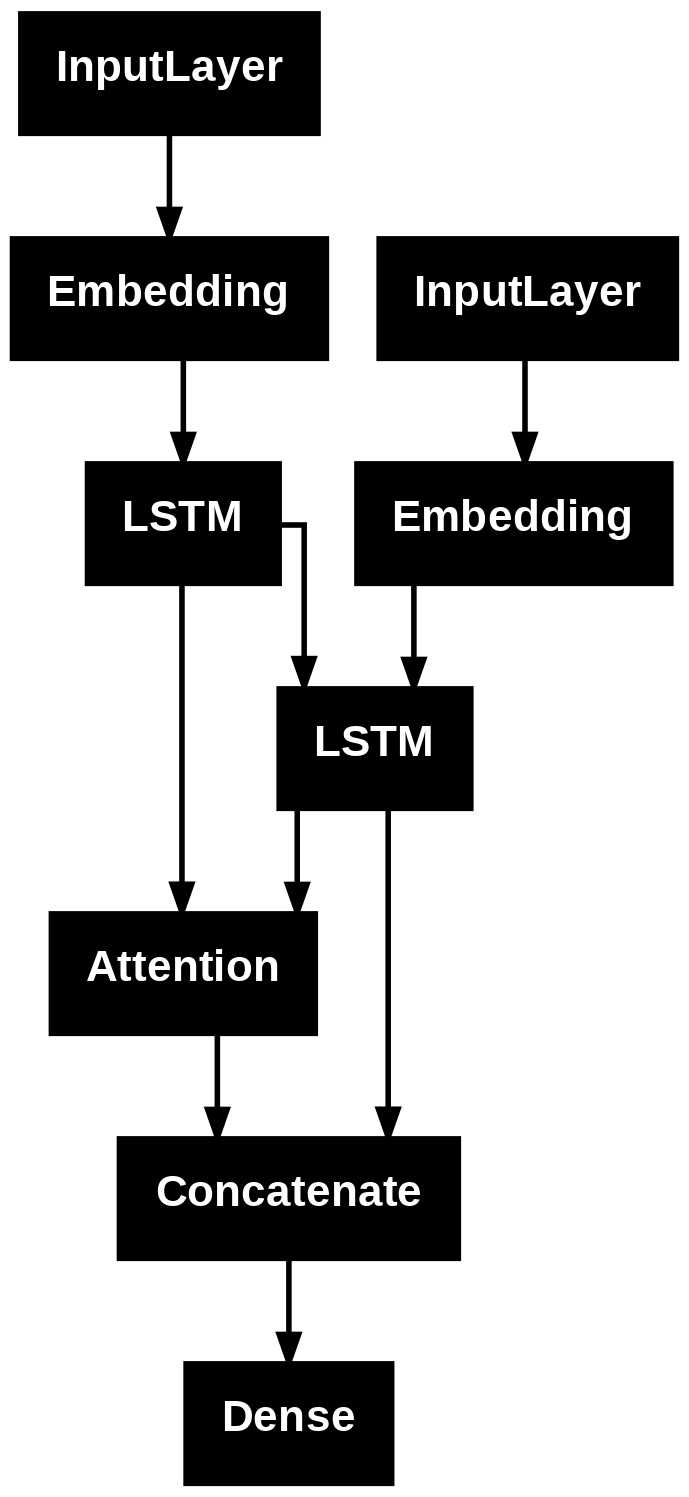

In [ ]:
tf.keras.utils.plot_model(nmt_with_mulAtt)

In [ ]:
nmt_with_mulAtt.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["sparse_categorical_accuracy"])
nmt_with_mulAtt.fit([input_data,decoder_input_data],decoder_output_data,epochs=30)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 8.9852 - sparse_categorical_accuracy: 0.0741
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.5055 - sparse_categorical_accuracy: 0.0741
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8.1839 - sparse_categorical_accuracy: 0.0741
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 8.0135 - sparse_categorical_accuracy: 0.1111
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 8.0372 - sparse_categorical_accuracy: 0.1111
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 8.0266 - sparse_categorical_accuracy: 0.0741
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 8.0008 - sparse_categorical_accuracy: 0.1111
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 7.9762 - sparse_categorical_accuracy: 0.1111
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 7.9519 - sparse_categorical_accuracy: 0.1481
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 7.9239 - sparse_categ

# Multi Head Attention

In [ ]:
#Encoder
encoder_input=tf.keras.layers.Input(shape=(None,))
encoder_embedding=tf.keras.layers.Embedding(vocab_size,embed_dim)(encoder_input)

enc_output,enc_h,enc_c=tf.keras.layers.LSTM(units,return_sequences=True,return_state=True)(encoder_embedding) #Normalement ça devait être un bidirectional LSTM

decoder_input=tf.keras.layers.Input(shape=(None,))
decoder_lstm = tf.keras.layers.LSTM(units,return_sequences=True,return_state=True)
decoder_embedding=tf.keras.layers.Embedding(vocab_size,embed_dim)(decoder_input)
#q k v
#Attention
mha_attention=tf.keras.layers.MultiHeadAttention(num_heads=4,key_dim=32)

decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=[enc_h,enc_c])

context_vector=mha_attention(query=decoder_output,value=enc_output,key=enc_output)
#Concaténation
rich_vector=tf.keras.layers.concatenate([context_vector,decoder_output],axis=-1)
logits = tf.keras.layers.Dense(vocab_size)(rich_vector) # Apply dense layer to LSTM output
nmt_with_MHA=Model(inputs=[encoder_input,decoder_input],outputs=logits)

In [ ]:
nmt_with_MHA.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["sparse_categorical_accuracy"])
nmt_with_MHA.fit([input_data,decoder_input_data],decoder_output_data,epochs=30)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 7.5282 - sparse_categorical_accuracy: 0.0370
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 7.2260 - sparse_categorical_accuracy: 0.0741
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 7.1454 - sparse_categorical_accuracy: 0.1111
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 7.0792 - sparse_categorical_accuracy: 0.0741
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 7.0032 - sparse_categorical_accuracy: 0.0741
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 6.9209 - sparse_categorical_accuracy: 0.0741
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 6.8412 - sparse_categorical_accuracy: 0.0741
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 6.4581 - sparse_categorical_accuracy: 0.0741
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 6.3114 - sparse_categorical_accuracy: 0.0741
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 6.2609 - sparse_catego

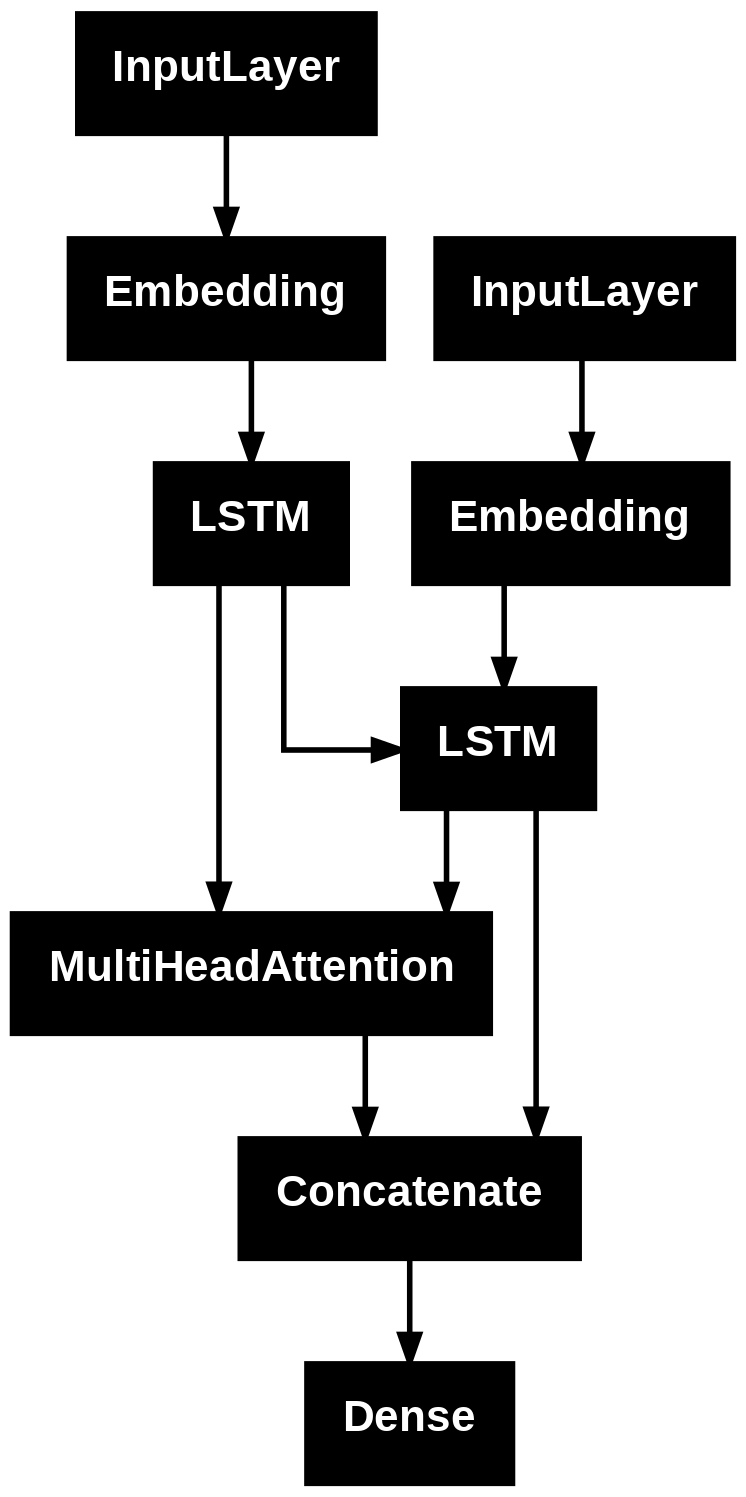

In [ ]:
tf.keras.utils.plot_model(nmt_with_MHA)

In [ ]:
for i in range(len(nmt_with_MHA.layers)):
  print(f"Layer {i} : {nmt_with_MHA.layers[i]}")

Layer 0 : <InputLayer name=input_layer_35, built=True>
Layer 1 : <Embedding name=embedding_36, built=True>
Layer 2 : <InputLayer name=input_layer_36, built=True>
Layer 3 : <LSTM name=lstm_37, built=True>
Layer 4 : <Embedding name=embedding_37, built=True>
Layer 5 : <LSTM name=lstm_38, built=True>
Layer 6 : <MultiHeadAttention name=multi_head_attention_1, built=True>
Layer 7 : <Concatenate name=concatenate_7, built=True>
Layer 8 : <Dense name=dense_10, built=True>


In [ ]:
inf_embedding=nmt_with_MHA.layers[1](tf_src)
out,h,c=nmt_with_MHA.layers[3](inf_embedding)

j=0
inputs_j=[1]
reverse_english={id:word for word,id in en_to_id.items()}
results_id=[]
#while True:
for j in range(25):
  target_ids=np.array([inputs_j])
  #DECODER EMBEDDING
  embed_target=nmt_with_MHA.layers[4](target_ids)
  #LSTM
  dec_out,dec_h,dec_c=nmt_with_MHA.layers[5](embed_target,initial_state=[h,c])

  context=nmt_with_MHA.layers[6](query=dec_out,value=out,key=out)
  att_out=nmt_with_MHA.layers[7]([context,dec_out])
  #Sortie dense
  att_dense=nmt_with_MHA.layers[8]
  logits=att_dense(att_out)
  logits=logits[:,-1,:]
  pred_id=tf.argmax(logits,axis=1)
  #print(pred_id)
  #print("Indice prédit",pred_id.numpy())
  token_id=pred_id.numpy()[0]
  results_id.append(token_id)  #target_id=list(pred_id.numpy()[0])

  inputs_j.append(j+1)
print("Result_ids",results_id)
response=[reverse_english[i] for i in results_id if i in en_to_id.values() ]#elif i==max(en_to_id.values()+1)]
print("Entrée :",french)
print(" ".join(response))


Result_ids [np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(6), np.int64(7), np.int64(6), np.int64(7), np.int64(6), np.int64(6), np.int64(12), np.int64(6), np.int64(14), np.int64(15), np.int64(6), np.int64(6), np.int64(6), np.int64(19), np.int64(21), np.int64(21), np.int64(21), np.int64(23), np.int64(24), np.int64(25)]
Entrée : Les sciences exactes, telles que les mathématiques et la physique, étudient des phénomènes mesurables et prédictibles. Elles reposent sur des démonstrations rigoureuses et des observations empiriques, menant à une compréhension approfondie du monde.
as as as as as and physics and physics and and They and on rigorous and and and leading a a a understanding of the
